In [1]:
import os, glob
from os.path import join
from scipy.stats import zscore
from scipy.stats import pearsonr

# import mvpa2 as mv
# from mvpa2.base.hdf5 import h5load
# from mvpa2.datasets.gifti import gifti_dataset
import sys
import nibabel as nib
import numpy as np
from matplotlib import colors
from nilearn import datasets
from nilearn import surface
import nilearn
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


TODO list
* load in group data
* apply fisher mean
* average across p
* plot

In [2]:
def double_cmap(cm=plt.cm.inferno, n_colors=100): 
    double_c = np.vstack((cm(np.linspace(0, 1, n_colors)),
                          cm(np.linspace(0, 1, n_colors))))
                          
    return colors.ListedColormap(double_c)

In [3]:
def read_gifti(gifti_fn):
    gii = nib.load(gifti_fn)
    data = np.vstack([da.data[np.newaxis, :]
                      for da in gii.darrays])
    return data

In [4]:
def write_gifti(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    if data.ndim == 1:
        data = data[np.newaxis, :]
    for row in data:
        gda = nib.gifti.GiftiDataArray(row)
        gii.add_gifti_data_array(gda)
    nib.gifti.giftiio.write(gii, output_fn)

In [5]:
# Custom mean estimator with Fisher z transformation for correlations
# code from Sam
def fisher_mean(correlation, axis=None):
    return np.tanh(np.nanmean(np.arctanh(correlation), axis=axis))

## load one participant example
## stack participants

In [16]:
subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000001.npy

/Volumes/life-encoding/scripts/isc
subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000001.npy

SyntaxError: invalid decimal literal (3339943004.py, line 1)

In [6]:
# parameters
# gifti_dir = '/dartfs/rc/lab/D/DBIC/DBIC/life_data/life_dataset'
# gifti_dir = '/Volumes/rc/lab/D/DBIC/DBIC/life_data/life_dataset' # heejung local
data_dir = '/Volumes/life-encoding'
isc_dir = join(data_dir, 'scripts', 'isc')
runs = [1, 2, 3, 4]
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']
align = 'aa'
hemi = 'lh'
# run = 1

In [7]:
runs = [1]
for run in runs:

    per_run = []
    for subject in subjects:
        fname = join(isc_dir, f'subjectwise-ISC_align-{align}_hemi-{hemi}_run-0{run}_{subject}.npy')
        print(fname)
        data = np.load(fname)
        per_run.append(data)
        print(f'individual gifti data shape: {data.shape}')
    all_data = np.squeeze(np.array(per_run))
    print(f'stacked data shape: {all_data.shape}')

/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000001.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000005.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000006.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000009.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000012.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000014.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_run-01_sub-rid000017.npy
individual gifti data shape: (1, 40962)
/Volumes/life-encoding/scripts/isc/subjectwise-ISC_align-aa_hemi-lh_r

In [8]:
all_data
group_fisher = fisher_mean(all_data,axis = 0)

In [9]:
suma_dir = '/Users/h/suma-fsaverage6'
write_gifti(group_fisher.astype(float),
    template_fn = os.path.join(suma_dir, 'lh.pial.gii'), 
    output_fn = os.path.join(f'/Volumes/life-encoding/scripts/isc/groupaverage-fisher-ISC_align-{align}_hemi-{hemi}_run-{run:02d}_.gii'))


/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_96842/3189128796.py:10: DeprecationWarning: giftiio.write function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  nib.gifti.giftiio.write(gii, output_fn)


## plot gifti

In [10]:
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt
suma_dir = '/Users/h/suma-fsaverage6'
fsaverage_gii_L = os.path.join(suma_dir, 'lh.pial.gii')
fsaverage_gii_R = os.path.join(suma_dir, 'rh.pial.gii')
fsaverage_inflated_L = os.path.join(suma_dir, 'lh.inflated.gii')
fsaverage_inflated_R = os.path.join(suma_dir, 'rh.inflated.gii')
isc_fisher = os.path.join(f'/Volumes/life-encoding/scripts/isc/groupaverage-fisher-ISC_align-{align}_hemi-{hemi}_run-{run:02d}_.gii')


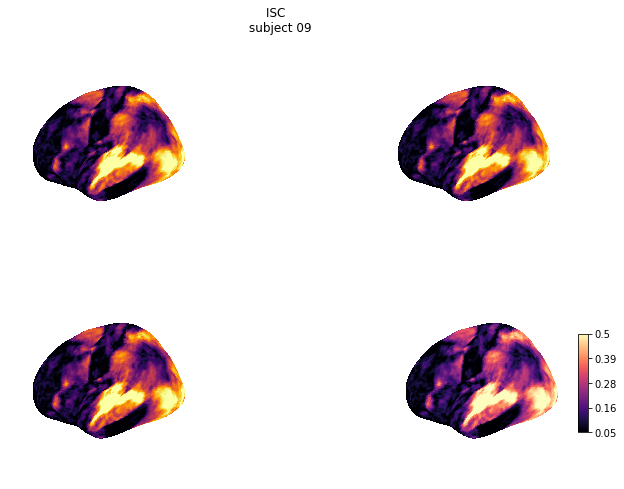

In [11]:
# f, axs = plt.subplots(2, 2)
figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize = (12,8))
plot_surf(fsaverage_inflated_L,isc_fisher, 
          title='ISC \n behavior attention task\n left hemi', 
          hemi='left', view = 'lateral', vmin=.05, vmax=.5, cmap = 'inferno',axes=axes[0][0])
plot_surf(fsaverage_inflated_L,isc_fisher, 
title='ISC \n behavior attention task\n left hemi', 
hemi='left', view = 'lateral', vmin=.05, vmax=.50, cmap = 'inferno',axes=axes[0][1])
plot_surf(fsaverage_inflated_L,isc_fisher, 
title='ISC \n behavior attention task\n left hemi', 
hemi='left', view = 'lateral', vmin=.05, vmax=.50, cmap = 'inferno',axes=axes[1][0])
plot_surf(fsaverage_inflated_L,isc_fisher, 
title='ISC \n subject 09', colorbar=True,
hemi='left', view = 'lateral', vmin=.05, vmax=.50, cmap = 'magma',axes=axes[1][1])

plt.show()

## full loop

In [24]:
hemi_view = {'lh':'left', 'rh': 'right'}
hemi_view['lh']

'left'

stacked data shape: (18, 40962)


/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_96842/3189128796.py:10: DeprecationWarning: giftiio.write function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  nib.gifti.giftiio.write(gii, output_fn)


stacked data shape: (18, 40962)
stacked data shape: (18, 40962)
stacked data shape: (18, 40962)
stacked data shape: (18, 40962)
stacked data shape: (18, 40962)
stacked data shape: (18, 40962)
stacked data shape: (18, 40962)


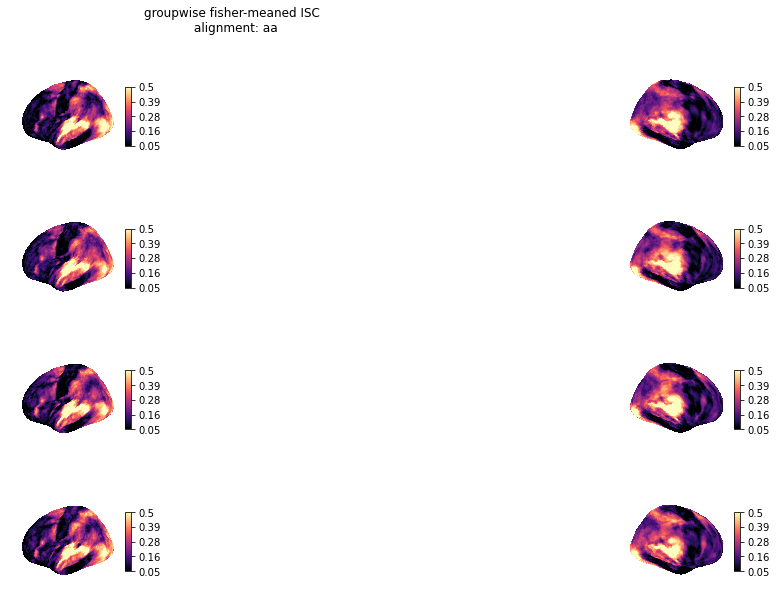

In [35]:
#runs = [1]
axes_dict = {'lh':
[[0,0],[1,0],[2,0],[3,0]],
'rh':
[[0,1],[1,1],[2,1],[3,1]]
}
hemi_view = {'lh':'left', 'rh': 'right'}

for align in ['aa']:#[ 'ha_common', 'ha_test']: # 'aa'
    figure, axes = plt.subplots(4,2,subplot_kw={'projection': '3d'},figsize = (20,10))
    for hemi in ['lh', 'rh']:
        for run in [1,2,3,4]:

            per_run = []
            for subject in subjects:
                fname = join(isc_dir, f'subjectwise-ISC_align-{align}_hemi-{hemi}_run-0{run}_{subject}.npy')
                #print(fname)
                data = np.load(fname)
                per_run.append(data)
                #print(f'individual gifti data shape: {data.shape}')
            all_data = np.squeeze(np.array(per_run))
            print(f'stacked data shape: {all_data.shape}')
            #all_data
            group_fisher = fisher_mean(all_data,axis = 0)
            suma_dir = '/Users/h/suma-fsaverage6'
            write_gifti(group_fisher.astype(float),
            template_fn = os.path.join(suma_dir, 'lh.pial.gii'), 
            output_fn = os.path.join(f'/Volumes/life-encoding/scripts/isc/groupaverage-fisher-ISC_align-{align}_hemi-{hemi}_run-{run:02d}_.gii'))

            suma_dir = '/Users/h/suma-fsaverage6'
            fsaverage_gii_L = os.path.join(suma_dir, 'lh.pial.gii')
            fsaverage_gii_R = os.path.join(suma_dir, 'rh.pial.gii')
            fsaverage_inflated_L = os.path.join(suma_dir, 'lh.inflated.gii')
            fsaverage_inflated_R = os.path.join(suma_dir, 'rh.inflated.gii')
            isc_fisher = os.path.join(f'/Volumes/life-encoding/scripts/isc/groupaverage-fisher-ISC_align-{align}_hemi-{hemi}_run-{run:02d}_.gii')

        # f, axs = plt.subplots(2, 2)
            
            display = plot_surf(fsaverage_inflated_L,isc_fisher, 
            title=f'groupwise fisher-meaned ISC \n alignment: {align}', colorbar=True,
            hemi=hemi_view[hemi], view = 'lateral', 
            vmin=.05, vmax=.50, cmap = 'magma',axes=axes[axes_dict[hemi][run-1][0]][axes_dict[hemi][run-1][1]])
    display.savefig(join(isc_dir, f'plot_groupaverage-fisher-ISC_align-{align}.png')    )

    plt.show()
    #display.close() 

In [32]:
display =        plot_surf(fsaverage_inflated_L,isc_fisher, 
        title='ISC \n subject 09', colorbar=True,
        hemi=hemi_view[hemi], view = 'lateral', 
        vmin=.05, vmax=.50, cmap = 'magma',axes=axes[axes_dict[hemi][run-1][0]][axes_dict[hemi][run-1][1]])

display.savefig(join(isc_dir, f'plot_groupaverage-fisher-ISC_align-{align}_hemi-{hemi}.png')    )

<Figure size 432x288 with 0 Axes>